# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [63]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [64]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import requests
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

### Variables

In [65]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
max_nan_in_row = 0.8 # if nan_amount > max_nan_in_row*len(columns) then remove that column
outlier = 3
train_new_model = {'True': True, 'False': False}.get(input('Train new models? (Bool)'))
debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))

### Select symbols for training

In [66]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()
symbols = pd.Series(symbols).unique()

## Data Preparation

#### Test load

In [67]:
test_stock = Stock("LLY").get_df_financials()
if debugging:
    display(test_stock)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,Receivables,OtherReceivables,AccountsReceivable,AllowanceForDoubtfulAccountsReceivable,GrossAccountsReceivable,CashCashEquivalentsAndShortTermInvestments,OtherShortTermInvestments,CashAndCashEquivalents,CashEquivalents,CashFinancial
0,LLY,Eli Lilly and Company,2025-09-30,0,Healthcare,Drug Manufacturers - General,763.000000,NaN,-2.221265e+08,0.228126,...,1.945720e+10,3.349800e+09,1.610740e+10,-21700000.0,1.612910e+10,9.913500e+09,121600000.0,9.791900e+09,NaN,NaN
1,LLY,Eli Lilly and Company,2025-06-30,1,Healthcare,Drug Manufacturers - General,777.821594,-0.065968,-6.554043e+06,0.164674,...,1.720560e+10,3.035200e+09,1.417040e+10,-16100000.0,1.418650e+10,3.546000e+09,170100000.0,3.375900e+09,NaN,NaN
2,LLY,Eli Lilly and Company,2025-03-31,2,Healthcare,Drug Manufacturers - General,822.414185,-0.054222,-3.541868e+08,0.202000,...,1.400320e+10,1.966600e+09,1.203660e+10,-15500000.0,1.205210e+10,3.220700e+09,127400000.0,3.093300e+09,NaN,NaN
3,LLY,Eli Lilly and Company,2024-12-31,3,Healthcare,Drug Manufacturers - General,767.409790,0.044842,-6.914325e+08,0.165000,...,1.327540e+10,2.269700e+09,1.100570e+10,-14900000.0,1.102060e+10,3.423200e+09,154800000.0,3.268400e+09,NaN,NaN
4,LLY,Eli Lilly and Company,2024-09-30,4,Healthcare,Drug Manufacturers - General,879.216125,-0.125086,-1.087488e+09,0.389000,...,1.205170e+10,1.756900e+09,1.029480e+10,-15700000.0,1.031050e+10,3.518400e+09,149400000.0,3.369000e+09,NaN,NaN
5,LLY,Eli Lilly and Company,2023-12-31,5,Healthcare,Drug Manufacturers - General,573.652344,0.341695,-7.814277e+08,0.201000,...,1.133620e+10,2.245700e+09,9.090500e+09,-14800000.0,9.105300e+09,2.927700e+09,109100000.0,2.818600e+09,1.088400e+09,1.730200e+09
6,LLY,Eli Lilly and Company,2022-12-31,6,Healthcare,Drug Manufacturers - General,357.777649,-0.058246,-1.297954e+08,0.083000,...,8.558900e+09,1.662900e+09,6.896000e+09,-16000000.0,6.912000e+09,2.211800e+09,144800000.0,2.067000e+09,6.574000e+08,1.409600e+09
7,LLY,Eli Lilly and Company,2021-12-31,7,Healthcare,Drug Manufacturers - General,266.490448,0.063977,-1.408485e+08,0.093000,...,8.127200e+09,1.454400e+09,6.672800e+09,-22500000.0,6.695300e+09,3.908600e+09,90100000.0,3.818500e+09,2.379500e+09,1.439000e+09


#### Download annual financial data

In [68]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            for i in range(len(ticker_df)):
                if ticker_df.loc[i].isna().sum() > len(ticker_df.columns)*max_nan_in_row:
                    ticker_df = ticker_df.drop(i)
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "Price", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised: \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [69]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,CommercialPaper,CurrentNotesPayable,PreferredStockDividends,PreferredSecuritiesOutsideStockEquity,NonCurrentNoteReceivables,LossAdjustmentExpense,NetPolicyholderBenefitsAndClaims,LoansReceivable,DuetoRelatedPartiesCurrent,AccruedInterestReceivable
0,MATAS.CO,Matas A/S,2025-09-30,0.0,Consumer Cyclical,Specialty Retail,130.000000,NaN,-2.483871e+06,0.225806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MATAS.CO,Matas A/S,2025-06-30,1.0,Consumer Cyclical,Specialty Retail,133.399994,-0.025487,-1.097561e+06,0.219512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MATAS.CO,Matas A/S,2025-03-31,2.0,Consumer Cyclical,Specialty Retail,130.047333,0.025780,-7.209000e+06,0.267000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MATAS.CO,Matas A/S,2024-12-31,3.0,Consumer Cyclical,Specialty Retail,133.397034,-0.025111,-2.443609e+05,0.244361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MATAS.CO,Matas A/S,2024-09-30,4.0,Consumer Cyclical,Specialty Retail,122.756798,0.086677,1.129032e+06,0.225806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,HLUN-B.CO,H. Lundbeck A/S B,2025-03-31,2.0,Healthcare,Drug Manufacturers - Specialty & Generic,34.700001,0.047839,0.000000e+00,0.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,HLUN-B.CO,H. Lundbeck A/S B,2024-12-31,3.0,Healthcare,Drug Manufacturers - Specialty & Generic,40.296162,-0.138876,6.184500e+07,0.155000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,HLUN-B.CO,H. Lundbeck A/S B,2024-09-30,4.0,Healthcare,Drug Manufacturers - Specialty & Generic,42.227100,-0.045727,0.000000e+00,0.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,HLUN-B.CO,H. Lundbeck A/S B,2023-12-31,5.0,Healthcare,Drug Manufacturers - Specialty & Generic,30.970766,0.046047,-6.345000e+06,0.235000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [70]:
imputer = SimpleImputer()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

c:\Users\Gamer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['LoansReceivable']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


### Feature engineering

C:\Users\Gamer\AppData\Local\Temp\ipykernel_12640\872096102.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["PE"] = df["Price"]/(df["BasicEPS"])
Traceback (most recent call last):
  File "C:\Users\Gamer\AppData\Local\Temp\ipykernel_12640\852826709.py", line 500, in _repr_dw_
    return self._gen_json()
           ~~~~~~~~~~~~~~^^
  File "C:\Users\Gamer\AppData\Local\Temp\ipykernel_12640\852826709.py", line 508, in _gen_json
    return api["pandas_transport"]["get_df_payload"](tmp_vars[self.id]["converted"], max_num_rows_to_preload, **kwargs)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gamer\AppData\Local\Temp\ipykernel_12640\852826709.py", line 248, in get_df

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,CurrentNotesPayable,PreferredStockDividends,PreferredSecuritiesOutsideStockEquity,NonCurrentNoteReceivables,LossAdjustmentExpense,NetPolicyholderBenefitsAndClaims,LoansReceivable,DuetoRelatedPartiesCurrent,AccruedInterestReceivable,PE
0,27,Matas A/S,2025-09-30,0.0,2,27,130.000000,NaN,-2.483871e+06,0.225806,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,203.125000
1,27,Matas A/S,2025-06-30,1.0,2,27,133.399994,-0.025487,-1.097561e+06,0.219512,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,79.880236
2,27,Matas A/S,2025-03-31,2.0,2,27,130.047333,0.025780,-7.209000e+06,0.267000,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,17.526595
3,27,Matas A/S,2024-12-31,3.0,2,27,133.397034,-0.025111,-2.443609e+05,0.244361,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,25.169252
4,27,Matas A/S,2024-09-30,4.0,2,27,122.756798,0.086677,1.129032e+06,0.225806,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,191.807497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,20,H. Lundbeck A/S B,2025-03-31,2.0,6,8,34.700001,0.047839,0.000000e+00,0.220000,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,29.913794
421,20,H. Lundbeck A/S B,2024-12-31,3.0,6,8,40.296162,-0.138876,6.184500e+07,0.155000,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,12.711723
422,20,H. Lundbeck A/S B,2024-09-30,4.0,6,8,42.227100,-0.045727,0.000000e+00,0.220000,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,54.137308
423,20,H. Lundbeck A/S B,2023-12-31,5.0,6,8,30.970766,0.046047,-6.345000e+06,0.235000,...,0.0,0.0,2.205714e+08,7.438113e+07,3.775062e+10,2.021275e+10,0.0,1.010667e+09,7047750.0,13.407258


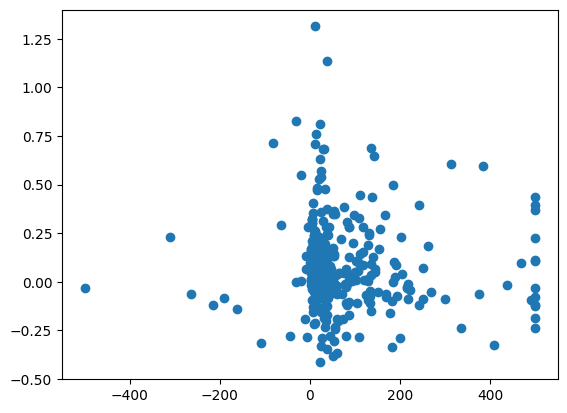

In [71]:
df["PE"] = df["Price"]/(df["BasicEPS"])
pe_limit = 500
df["PE"] = df["PE"].apply(lambda x: pe_limit if x > pe_limit else x)
df["PE"] = df["PE"].apply(lambda x: -pe_limit if x < -pe_limit else x)
if debugging:
    display(df)
    plt.scatter(df["PE"].to_list(), df["3M Future Change"].to_list())
    plt.show()

### Scaling

In [72]:
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

### Splitting

In [73]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,CurrentNotesPayable,PreferredStockDividends,PreferredSecuritiesOutsideStockEquity,NonCurrentNoteReceivables,LossAdjustmentExpense,NetPolicyholderBenefitsAndClaims,LoansReceivable,DuetoRelatedPartiesCurrent,AccruedInterestReceivable,PE
0,27,Matas A/S,2025-09-30,0.0,2,27,130.000000,NaN,0.010038,0.333005,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,1.005426
1,51,Trifork Group AG,2025-06-30,0.0,8,13,93.500000,NaN,0.017110,-1.721634,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,-4.384175
2,42,RHEINMETALL AG I,2025-09-30,0.0,7,0,1988.500000,NaN,0.017152,1.365330,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,3.281036
3,44,SAAB AB ser. B,2025-06-30,0.0,7,0,526.669800,NaN,0.017152,0.223784,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.864934
4,4,BAE Systems PLC,2024-12-31,0.0,7,0,56.118683,NaN,0.009935,-0.335395,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,-0.385868
5,23,KONGSBERG GRUPPEN,2025-06-30,0.0,7,0,387.953918,NaN,0.111889,0.092850,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,1.055862
6,15,Genmab A/S,2025-09-30,0.0,6,4,1927.500000,NaN,0.014265,-0.509770,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,1.245772
7,16,GN Store Nord A/S,2025-06-30,0.0,6,19,97.500000,NaN,0.016511,0.306652,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.109809
8,38,NVIDIA Corporation,2025-07-31,0.0,8,23,177.859970,NaN,0.017152,-0.729379,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.710777
9,25,Eli Lilly and Company,2025-09-30,0.0,6,7,763.000000,NaN,-0.619044,0.366859,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.386966


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,CurrentNotesPayable,PreferredStockDividends,PreferredSecuritiesOutsideStockEquity,NonCurrentNoteReceivables,LossAdjustmentExpense,NetPolicyholderBenefitsAndClaims,LoansReceivable,DuetoRelatedPartiesCurrent,AccruedInterestReceivable,PE
0,27,Matas A/S,2025-06-30,1.0,2,27,133.399994,-0.025487,0.014009,0.241163,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.060729
1,51,Trifork Group AG,2025-03-31,1.0,8,13,84.099998,0.111772,0.017055,2.072283,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,3.281036
2,42,RHEINMETALL AG I,2025-06-30,1.0,7,0,1797.000000,0.106566,0.017152,0.553388,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,3.281036
3,44,SAAB AB ser. B,2025-03-31,1.0,7,0,391.998016,0.343552,0.017152,0.102364,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.716256
4,4,BAE Systems PLC,2023-12-31,1.0,7,0,54.674278,0.216240,-0.142293,-0.189475,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,-0.380652
5,23,KONGSBERG GRUPPEN,2025-03-31,1.0,7,0,302.942139,0.280621,0.676969,0.245687,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.345693
6,15,Genmab A/S,2025-06-30,1.0,6,4,1315.000000,0.393156,0.044839,0.039239,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,1.301326
7,16,GN Store Nord A/S,2025-03-31,1.0,6,19,107.050003,-0.089211,0.017152,0.277468,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,1.123044
8,38,NVIDIA Corporation,2025-04-30,1.0,8,23,108.906296,0.646001,0.017152,-0.875299,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.532573
9,25,Eli Lilly and Company,2025-06-30,1.0,6,7,777.821594,-0.065968,-0.001619,-0.559032,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.000000,0.000000,0.0,1.317001e-14,0.000000,0.394806


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,CurrentNotesPayable,PreferredStockDividends,PreferredSecuritiesOutsideStockEquity,NonCurrentNoteReceivables,LossAdjustmentExpense,NetPolicyholderBenefitsAndClaims,LoansReceivable,DuetoRelatedPartiesCurrent,AccruedInterestReceivable,PE
0,27,Matas A/S,2025-03-31,2.0,2,27,130.047333,0.025780,-0.003495,0.934108,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.417225
1,27,Matas A/S,2024-12-31,3.0,2,27,133.397034,-0.025111,0.016453,0.603760,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.358642
2,27,Matas A/S,2024-09-30,4.0,2,27,122.756798,0.086677,0.020386,0.333005,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,0.918675
3,27,Matas A/S,2024-03-31,5.0,2,27,113.376465,0.006267,-0.075908,1.686296,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.356276
4,27,Matas A/S,2023-03-31,6.0,2,27,79.810799,0.221444,0.009371,0.642268,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.469010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,20,H. Lundbeck A/S B,2025-03-31,2.0,6,8,34.700001,0.047839,0.017152,0.248284,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.322274
305,20,H. Lundbeck A/S B,2024-12-31,3.0,6,8,40.296162,-0.138876,0.194284,-0.700195,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.454132
306,20,H. Lundbeck A/S B,2024-09-30,4.0,6,8,42.227100,-0.045727,0.017152,0.248284,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.136596
307,20,H. Lundbeck A/S B,2023-12-31,5.0,6,8,30.970766,0.046047,-0.001020,0.467164,...,0.0,0.0,-9.864493e-16,-1.202098e-15,0.0,0.0,0.0,1.317001e-14,0.0,-0.448800


### Labeling

In [74]:
training_columns = ["Ticker", "Earn Index", "Sector", "Industry", "PE"]
label_columns = ["3M Future Change"]
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,Sector,Industry,PE
0,27,0.0,2,27,1.005426
1,51,0.0,8,13,-4.384175
2,42,0.0,7,0,3.281036
3,44,0.0,7,0,0.864934
4,4,0.0,7,0,-0.385868
5,23,0.0,7,0,1.055862
6,15,0.0,6,4,1.245772
7,16,0.0,6,19,0.109809
8,38,0.0,8,23,0.710777
9,25,0.0,6,7,0.386966


X_test:


,Ticker,Earn Index,Sector,Industry,PE
0,27,1.0,2,27,0.060729
1,51,1.0,8,13,3.281036
2,42,1.0,7,0,3.281036
3,44,1.0,7,0,0.716256
4,4,1.0,7,0,-0.380652
5,23,1.0,7,0,0.345693
6,15,1.0,6,4,1.301326
7,16,1.0,6,19,1.123044
8,38,1.0,8,23,0.532573
9,25,1.0,6,7,0.394806


y_test:


,3M Future Change
0,-0.025487
1,0.111772
2,0.106566
3,0.343552
4,0.216240
5,0.280621
6,0.393156
7,-0.089211
8,0.646001
9,-0.065968


X_train:


,Ticker,Earn Index,Sector,Industry,PE
0,27,2.0,2,27,-0.417225
1,27,3.0,2,27,-0.358642
2,27,4.0,2,27,0.918675
3,27,5.0,2,27,-0.356276
4,27,6.0,2,27,-0.469010
...,...,...,...,...,...
304,20,2.0,6,8,-0.322274
305,20,3.0,6,8,-0.454132
306,20,4.0,6,8,-0.136596
307,20,5.0,6,8,-0.448800


y_train:


,3M Future Change
0,0.025780
1,-0.025111
2,0.086677
3,0.006267
4,0.221444
...,...
304,0.047839
305,-0.138876
306,-0.045727
307,0.046047


## Model Training

In [75]:
if train_new_model:
    predictions = []

    model = RandomForestRegressor(
        n_estimators=500,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

    model = MLPRegressor(
        hidden_layer_sizes=(500, 500),
        n_iter_no_change=30,
        learning_rate="adaptive",
        activation="tanh",
        early_stopping=True,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Iteration 1, loss = 5.78733011
Validation score: -48.901519
Iteration 2, loss = 2.29500153
Validation score: -351.840017
Iteration 3, loss = 9.40651535
Validation score: -64.482294
Iteration 4, loss = 1.41619068
Validation score: -30.701927
Iteration 5, loss = 1.36055904
Validation score: -103.027706
Iteration 6, loss = 2.96168654
Validation score: -50.712908
Iteration 7, loss = 1.25729696
Validation score: -2.952876
Iteration 8, loss = 0.12420202
Validation score: -17.578500
Iteration 9, loss = 0.64418860
Validation score: -35.151944
Iteration 10, loss = 1.03921003
Validation score: -24.003728
Iteration 11, loss = 0.64491416
Validation score: -6.322725
Iteration 12, loss = 0.16086504
Validation score: -3.338820
Iteration 13, loss = 0.13541276
Validation score: -9.523138
Iteration 14, loss = 0.31839723
Validation score: -11.014336
Iteration 15, loss = 0.33932631
Validation score: -5.911161
Iteration 16, loss = 0.17938257
Validation score: -1.671491
Iteration 17, loss = 0.06579626
Valid

c:\Users\Gamer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Testing and benchmarking

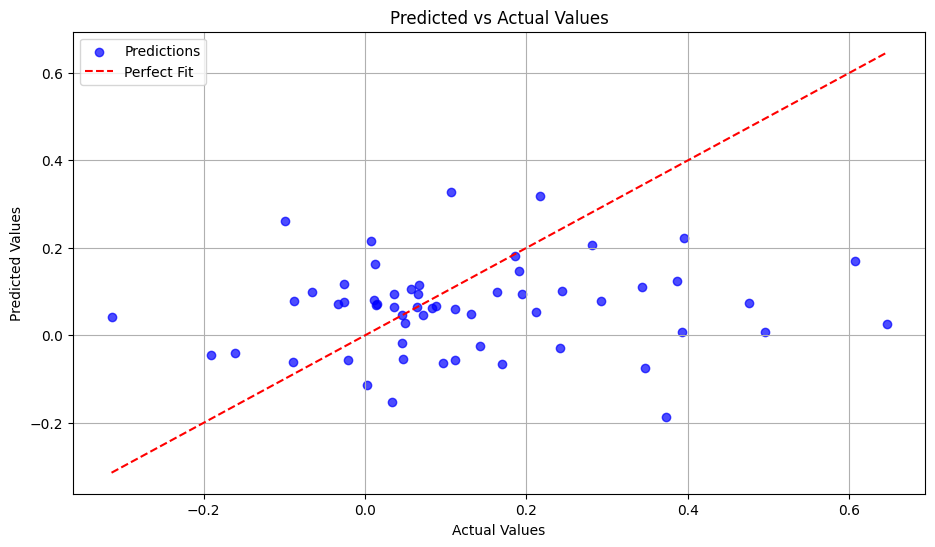

R²: -0.3211
MSE: 0.0465
MAE: 0.1599


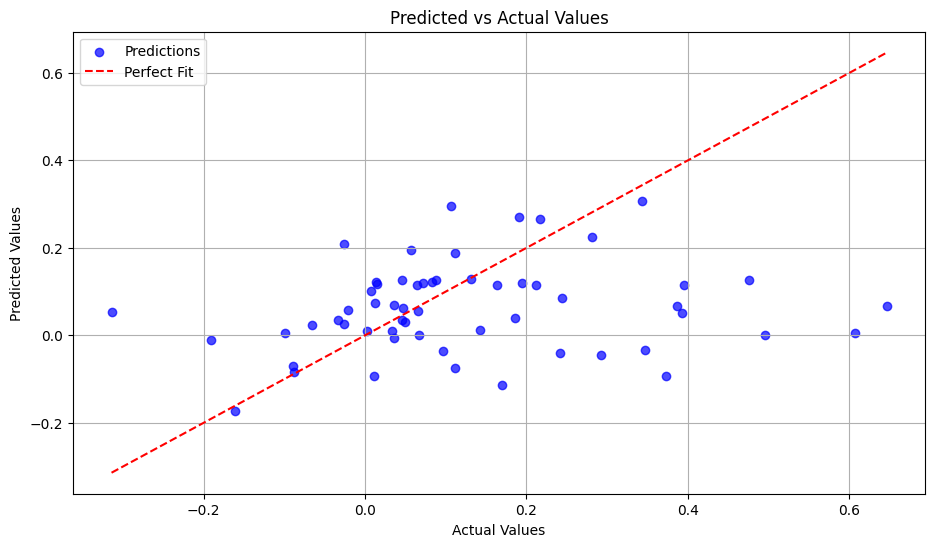

R²: -0.2366
MSE: 0.0435
MAE: 0.1461


In [76]:
if train_new_model:
    for y_pred in predictions:
        plt.figure(figsize=(11, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test.values.min(), y_test.values.max()], [y_test.values.min(), y_test.values.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'R²: {r2:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')

### Log test results

In [77]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

NameError: name 'iterations' is not defined

## Predictions on latest data

In [ ]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model.pkl'

In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Industry
- PE
- Sector
Feature names seen at fit time, yet now missing:
- Amortization
- AmortizationOfIntangiblesIncomeStatement
- AverageDilutionEarnings
- BasicAverageShares
- BasicEPS
- ...


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
